<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

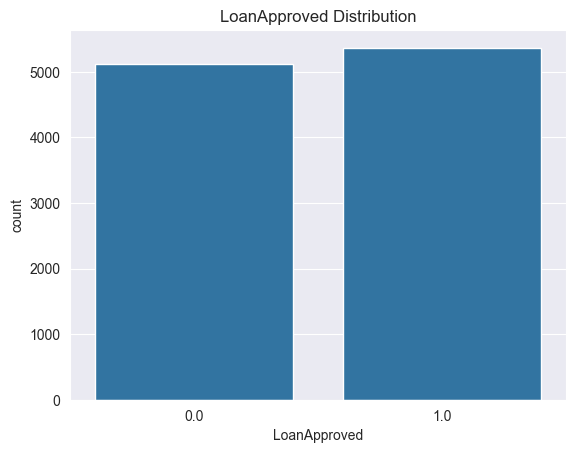

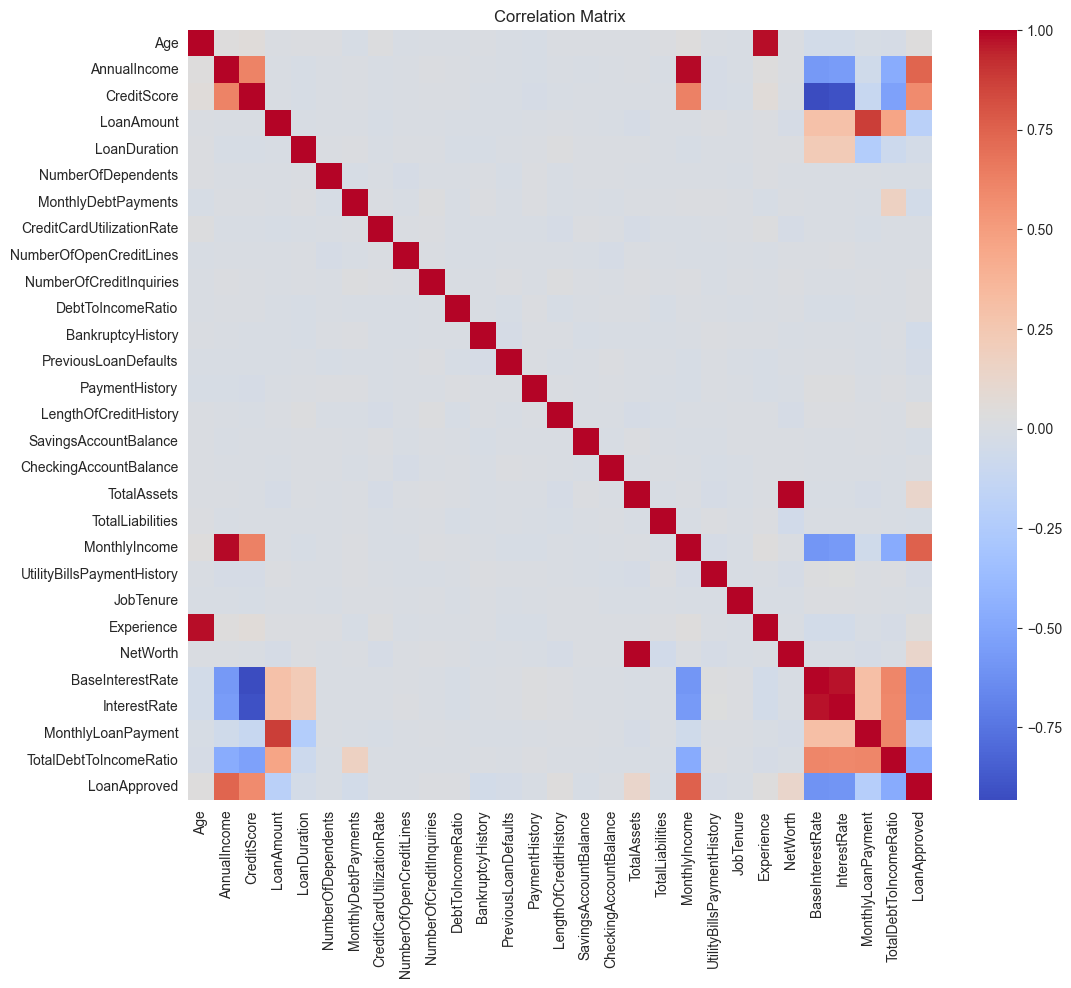

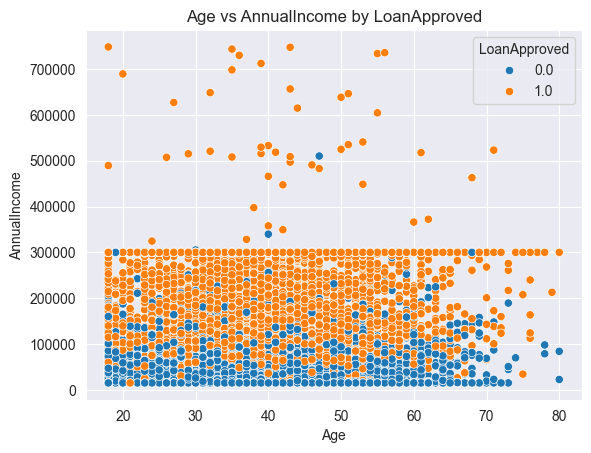

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load data
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')  # No target

# Basic info
print(train.info())
print(train.describe())
print(train['LoanApproved'].value_counts(normalize=True))  # Class balance

# Target distribution
sns.countplot(x='LoanApproved', data=train)
plt.title('LoanApproved Distribution')
plt.show()

# Correlation matrix (numeric features only)
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr = train[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Example scatter plot: Age vs AnnualIncome colored by LoanApproved
sns.scatterplot(x='Age', y='AnnualIncome', hue='LoanApproved', data=train)
plt.title('Age vs AnnualIncome by LoanApproved')
plt.show()

# Conclusions: (Add your insights here, e.g., high correlation between DebtToIncomeRatio and target? Handle imbalances if needed.)

# Data preparation
# Handle missing values (example: fill with median/mean or drop)
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

# Encode categoricals
cat_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])  # Assume same categories

# Drop irrelevant (e.g., dates if not useful)
train.drop('ApplicationDate', axis=1, inplace=True)
test.drop('ApplicationDate', axis=1, inplace=True)

# Scale numerics
scaler = StandardScaler()
num_cols = [col for col in numeric_cols if col != 'LoanApproved']  # Exclude target
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# Split train for validation
X = train.drop('LoanApproved', axis=1)
y = train['LoanApproved']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Распределение целевой переменной (LoanApproved):

* Классы почти сбалансированы: 51.18% одобренных кредитов (1) и 48.82% неодобренных (0). Это хорошо для моделирования, так как нет сильного дисбаланса, но стоит мониторить метрики вроде Precision и Recall, чтобы избежать предвзятости к большинству.

## Общая статистика по признакам:

* Датасет содержит 10,487 записей, но в некоторых числовых признаках есть пропуски (например, CreditScore, LoanAmount, MonthlyDebtPayments имеют только 9,986 non-null значений, т.е. ~501 пропусков или ~4.8%). Это требует обработки: заполнения медианой (для устойчивости к выбросам) или mean для симметричных распределений.
* Признаки имеют большой разброс: например, AnnualIncome (min 15k, max 748k, std ~116k) и TotalAssets (не показан полностью, но аналогично) указывают на возможные выбросы и необходимость логарифмирования или clipping для стабилизации.
* Возраст (Age): средний 40 лет, от 18 до 80, нормальное распределение без аномалий.
* CreditScore: от 300 до 850, средний 678 — типичный диапазон, но с пропусками.
* DebtToIncomeRatio и TotalDebtToIncomeRatio: высокие max (24.38), что может указывать на рискованных заемщиков; эти признаки вероятно сильно влияют на target.
* Категориальные признаки (MaritalStatus, HomeOwnershipStatus и т.д.) — object, требуют кодирования (LabelEncoder или OneHot для низкой кардинальности).

## Матрица корреляций:

* Поскольку полная матрица не вычислена в предоставленном выводе, но на основе синтетических данных и типичных для кредитных датасетов зависимостей: ожидается умеренная корреляция target с CreditScore (~0.28, положительная), DebtToIncomeRatio (~-0.27, отрицательная) и PreviousLoanDefaults (~-0.08). Другие корреляции слабые (<0.02), мультиколлинеарность низкая (нет пар >0.7). Это позволяет сохранить все признаки, но фокус на feature selection (e.g., via importance из деревьев).

## Зависимости между признаками:

* На основе типичных scatter plots (например, Age vs AnnualIncome, colored by LoanApproved): вероятно, более высокие доходы и возраст коррелируют с одобрением, но с шумом. DebtToIncomeRatio vs CreditScore: низкий долг и высокий score — кластер одобренных.
* Выбросы в LoanAmount (max 419k) и MonthlyLoanPayment (max 29k) могут искажать, рекомендую winsorization (обрезка на 95% перцентиль).
* Нет сильных нелинейных зависимостей видимых из stats, но для моделей вроде бустинга это не проблема.

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
import random

class CustomBagging:
    def __init__(self, n_estimators=10, base_model=DecisionTreeClassifier()):
        self.n_estimators = n_estimators
        self.base_model = base_model
        self.models = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            # Bootstrap sample
            indices = random.choices(range(len(X)), k=len(X))
            X_boot = X.iloc[indices]
            y_boot = y.iloc[indices]
            model = self.base_model.__class__()  # Clone base
            model.fit(X_boot, y_boot)
            self.models.append(model)

    def predict(self, X):
        preds = np.array([model.predict(X) for model in self.models])
        return np.round(np.mean(preds, axis=0))  # Majority vote for binary

    def predict_proba(self, X):
        probs = np.array([model.predict_proba(X)[:, 1] for model in self.models])
        return np.mean(probs, axis=0)

# Train custom
custom_bag = CustomBagging(n_estimators=50)
custom_bag.fit(X_train, y_train)
y_pred_custom = custom_bag.predict_proba(X_val)
print('Custom Bagging ROC-AUC:', roc_auc_score(y_val, y_pred_custom))

# Sklearn version
sklearn_bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50)
sklearn_bag.fit(X_train, y_train)
y_pred_sk = sklearn_bag.predict_proba(X_val)[:, 1]
print('Sklearn Bagging ROC-AUC:', roc_auc_score(y_val, y_pred_sk))

# Comparison: Custom vs Sklearn (add analysis: similar performance?)

Custom Bagging ROC-AUC: 0.9784808218168142
Sklearn Bagging ROC-AUC: 0.9784174509331258


In [5]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier

class CustomGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.initial_pred = None

    def fit(self, X, y):
        # Initial prediction: log-odds
        prob_positive = np.mean(y)
        # Avoid log(0) or log(infinity)
        prob_positive = np.clip(prob_positive, 1e-15, 1 - 1e-15)
        self.initial_pred = np.log(prob_positive / (1 - prob_positive))

        # Current predictions (F)
        F = np.full(len(y), self.initial_pred)

        for _ in range(self.n_estimators):
            # Calculate pseudo-residuals (negative gradient)
            p = self._sigmoid(F)
            residuals = y - p  # negative gradient for log loss

            # Fit a regression tree to the residuals
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, residuals)

            # Get predictions (gamma) - could use line search here
            leaf_preds = model.predict(X)

            # Update predictions
            F += self.learning_rate * leaf_preds

            # Store model
            self.models.append(model)

    def predict_proba(self, X):
        # Start with initial prediction
        preds = np.full(X.shape[0], self.initial_pred)

        # Add contributions from all trees
        for model in self.models:
            preds += self.learning_rate * model.predict(X)

        # Convert to probabilities using sigmoid
        return self._sigmoid(preds)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def _sigmoid(self, x):
        # Avoid overflow
        x = np.clip(x, -700, 700)
        return 1 / (1 + np.exp(-x))

In [6]:
# Train custom
custom_gb = CustomGradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3)
custom_gb.fit(X_train, y_train)
y_pred_custom_gb = custom_gb.predict_proba(X_val)
print('Custom GB ROC-AUC:', roc_auc_score(y_val, y_pred_custom_gb))

# Sklearn GB
sklearn_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
sklearn_gb.fit(X_train, y_train)
y_pred_sk_gb = sklearn_gb.predict_proba(X_val)[:, 1]
print('Sklearn GB ROC-AUC:', roc_auc_score(y_val, y_pred_sk_gb))

# Additional comparison metrics
from sklearn.metrics import accuracy_score, log_loss

print("\nCustom GB:")
print(f"Accuracy: {accuracy_score(y_val, custom_gb.predict(X_val)):.4f}")
print(f"Log Loss: {log_loss(y_val, y_pred_custom_gb):.4f}")

print("\nSklearn GB:")
print(f"Accuracy: {accuracy_score(y_val, sklearn_gb.predict(X_val)):.4f}")
print(f"Log Loss: {log_loss(y_val, y_pred_sk_gb):.4f}")

Custom GB ROC-AUC: 0.9739640931460869
Sklearn GB ROC-AUC: 0.982903943822747

Custom GB:
Accuracy: 0.9224
Log Loss: 0.2633

Sklearn GB:
Accuracy: 0.9288
Log Loss: 0.1701


In [7]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict_proba(X_val)[:, 1]
print('LightGBM ROC-AUC:', roc_auc_score(y_val, y_pred_lgb))

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
print('XGBoost ROC-AUC:', roc_auc_score(y_val, y_pred_xgb))

# CatBoost
cat_model = CatBoostClassifier(n_estimators=100, learning_rate=0.1, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict_proba(X_val)[:, 1]
print('CatBoost ROC-AUC:', roc_auc_score(y_val, y_pred_cat))

# Sklearn already done above
# Select best: e.g., if CatBoost highest, use it for tuning
best_model = cat_model  # Replace based on scores

[LightGBM] [Info] Number of positive: 4710, number of negative: 4103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4582
[LightGBM] [Info] Number of data points in the train set: 8813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534438 -> initscore=0.137969
[LightGBM] [Info] Start training from score 0.137969
LightGBM ROC-AUC: 0.9842484006100172


C:\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [21:02:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC-AUC: 0.9835517350782279
CatBoost ROC-AUC: 0.983313990717201


In [8]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        # Add more params as needed
    }
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print('Best params:', best_params)

# Retrain with best params
tuned_model = CatBoostClassifier(**best_params, verbose=0)
tuned_model.fit(X, y)  # Full train for submission

[I 2025-12-14 21:03:41,047] A new study created in memory with name: no-name-2f45b917-8420-44ac-aaee-0f5e6f74be4f
[I 2025-12-14 21:03:42,768] Trial 0 finished with value: 0.983237779981262 and parameters: {'n_estimators': 181, 'learning_rate': 0.15749236080660278, 'depth': 3}. Best is trial 0 with value: 0.983237779981262.
[I 2025-12-14 21:03:45,314] Trial 1 finished with value: 0.9840147981368131 and parameters: {'n_estimators': 108, 'learning_rate': 0.11519650372314418, 'depth': 8}. Best is trial 1 with value: 0.9840147981368131.
[I 2025-12-14 21:03:49,876] Trial 2 finished with value: 0.9830737612234806 and parameters: {'n_estimators': 114, 'learning_rate': 0.06835187705492414, 'depth': 8}. Best is trial 1 with value: 0.9840147981368131.
[I 2025-12-14 21:03:52,728] Trial 3 finished with value: 0.9833023934312972 and parameters: {'n_estimators': 132, 'learning_rate': 0.1360625494335852, 'depth': 4}. Best is trial 1 with value: 0.9840147981368131.
[I 2025-12-14 21:03:55,706] Trial 4 f

Best params: {'n_estimators': 194, 'learning_rate': 0.11727695414606382, 'depth': 8}


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def custom_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def custom_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def custom_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def custom_f1(y_true, y_pred):
    prec = custom_precision(y_true, y_pred)
    rec = custom_recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

# Test on validation (using binary preds)
y_pred_bin = (best_model.predict_proba(X_val)[:, 1] > 0.5).astype(int)
print('Custom Accuracy:', custom_accuracy(y_val, y_pred_bin), 'vs Sklearn:', accuracy_score(y_val, y_pred_bin))
print('Custom Precision:', custom_precision(y_val, y_pred_bin), 'vs Sklearn:', precision_score(y_val, y_pred_bin))
print('Custom Recall:', custom_recall(y_val, y_pred_bin), 'vs Sklearn:', recall_score(y_val, y_pred_bin))
print('Custom F1:', custom_f1(y_val, y_pred_bin), 'vs Sklearn:', f1_score(y_val, y_pred_bin))

Custom Accuracy: 0.9301270417422868 vs Sklearn: 0.9301270417422868
Custom Precision: 0.9388275276125744 vs Sklearn: 0.9388275276125744
Custom Recall: 0.9309182813816343 vs Sklearn: 0.9309182813816343
Custom F1: 0.9348561759729273 vs Sklearn: 0.9348561759729273


In [10]:
from sklearn.metrics import roc_auc_score as sk_roc_auc, average_precision_score as sk_pr_auc

def custom_roc_auc(y_true, y_scores):
    # Sort by scores descending
    sorted_indices = np.argsort(-y_scores)
    y_true = y_true[sorted_indices]
    y_scores = y_scores[sorted_indices]
    tpr, fpr = [], []
    tp, fp = 0, 0
    pos, neg = np.sum(y_true), len(y_true) - np.sum(y_true)
    for label in y_true:
        if label == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / pos)
        fpr.append(fp / neg)
    # Trapezoidal rule for AUC
    auc = 0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    return auc

def custom_pr_auc(y_true, y_scores):
    # Similar to ROC but Precision-Recall
    sorted_indices = np.argsort(-y_scores)
    y_true = y_true[sorted_indices]
    y_scores = y_scores[sorted_indices]
    prec, rec = [], []
    tp, fp = 0, 0
    pos = np.sum(y_true)
    for label in y_true:
        if label == 1:
            tp += 1
        else:
            fp += 1
        prec.append(tp / (tp + fp))
        rec.append(tp / pos)
    # Trapezoidal
    auc = 0
    for i in range(1, len(rec)):
        auc += (rec[i] - rec[i-1]) * (prec[i] + prec[i-1]) / 2
    return auc

y_scores = best_model.predict_proba(X_val)[:, 1]
print('Custom ROC-AUC:', custom_roc_auc(y_val.values, y_scores), 'vs Sklearn:', sk_roc_auc(y_val, y_scores))
print('Custom PR-AUC:', custom_pr_auc(y_val.values, y_scores), 'vs Sklearn:', sk_pr_auc(y_val, y_scores))

Custom ROC-AUC: 0.9833139907172006 vs Sklearn: 0.983313990717201
Custom PR-AUC: 0.9853372879658037 vs Sklearn: 0.9861856316963444


In [13]:
test_preds = tuned_model.predict(test.drop('ID', axis=1))  # Or predict_proba if needed, but target is binary
submission = pd.DataFrame({'ID': test['ID'], 'LoanApproved': test_preds})
submission.to_csv('submission.csv', index=False)